<a href="https://www.kaggle.com/code/serdargundogdu/gdz-enerji-makine-renmesi-prophet?scriptVersionId=126922114" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# İş Problemi

İzmir ve Manisa illerinde günlük yaşamın vazgeçilmezi olan elektrik enerjisini, insan odaklı hizmet anlayışı ve modern teknoloji sistemleri ile tüketicilerine ulaştıran Gdz Elektrik, geleneksel hale getirdiği Datathon serisinin ikincisinin çözümüdür.

Katılımcıların sunulan veri seti ile Gdz Elektrik sorumluluğundaki şebeke merkezlerine yönelik "enerji dağıtım" tahminleme yaklaşımı geliştirilmesi bekleniyor. 🎯

Kaggle yarışmasında başarı metriği MAPE (Mean Absolute Percentage Error) olacaktır.

# Veri Seti Hikayesi

Dosya

● med.csv - Major Event Day veri seti

● train.csv - Train veri seti

● sample_submission.csv - Örnek submission dosyası

Açıklamalar

Major Event Day (MED.CSV): Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün. Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

Dağıtılan Enerji: Watt: Aktif(yararlı) gücün birimi. MWh = MegaWatt saat

Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

Dış Veri Kullanımı Size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

In [1]:
# !pip install prophet

# Imports

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
plt.style.use('fivethirtyeight')

def custom_mape(y_true, y_pred):
    """Calculate MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
gdz = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv',
                index_col = [0],
                parse_dates=[0])
gdz.head()

,Dağıtılan Enerji (MWh)
Tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701


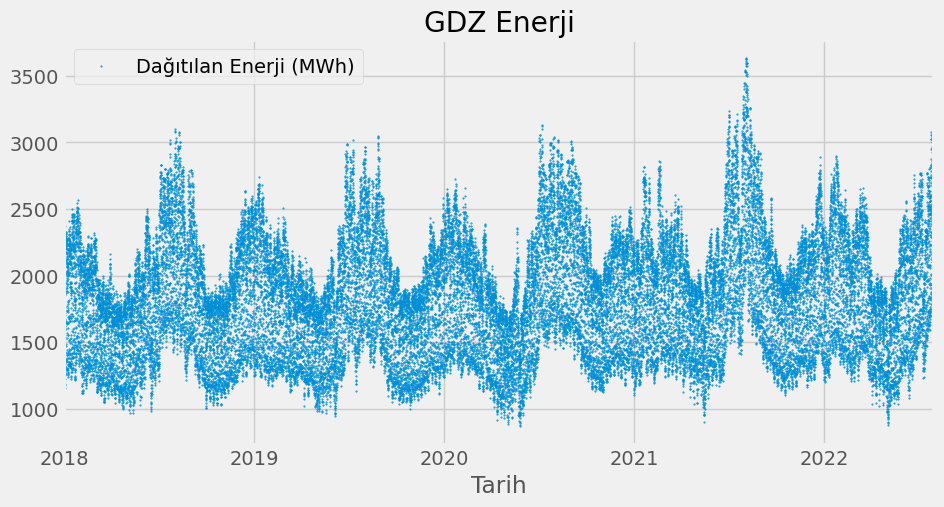

In [4]:
color_pal = sns.color_palette()
gdz.plot(style='.',
         figsize=(10, 5),
        ms=1,
        color=color_pal[0],
        title='GDZ Enerji')
plt.show()

# Zaman Serisi Özellikleri

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                       'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                           ordered=True)

def create_features(df, label=None):
    """
    Create time series features based on time series index
    Festival holidays
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                         labels = ['Spring', 'Summer', 'Fall', 'Winter'])
    
    df_med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv')
    df_med = df_med.set_index('Tarih')
    df_med.index = pd.to_datetime(df_med.index)
    df.drop(df.loc[df.index.strftime('%Y-%m-%d').isin(df_med.index.strftime('%Y-%m-%d'))].index,inplace=True)
   
    X = df[['hour', 'dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
            'season']]
    
        
    if label:
        y = df[label]
        return X, y
    
    return X

X, y = create_features(gdz, label='Dağıtılan Enerji (MWh)')
features_and_target = pd.concat([X, y], axis=1)

In [6]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Dağıtılan Enerji (MWh)
Tarih,,,,,,,,,,,
2018-01-01 00:00:00,0,0,1,1,2018,1,1,1,Monday,Winter,1593.944216
2018-01-01 01:00:00,1,0,1,1,2018,1,1,1,Monday,Winter,1513.933887
2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,Monday,Winter,1402.612637
2018-01-01 03:00:00,3,0,1,1,2018,1,1,1,Monday,Winter,1278.527266
2018-01-01 04:00:00,4,0,1,1,2018,1,1,1,Monday,Winter,1220.697701


In [7]:
features_and_target.count()

hour                      39432
dayofweek                 39432
quarter                   39432
month                     39432
year                      39432
dayofyear                 39432
dayofmonth                39432
weekofyear                39432
weekday                   39432
season                    39312
Dağıtılan Enerji (MWh)    39432
dtype: int64

In [8]:
features_and_target.isnull().sum()

hour                        0
dayofweek                   0
quarter                     0
month                       0
year                        0
dayofyear                   0
dayofmonth                  0
weekofyear                  0
weekday                     0
season                    120
Dağıtılan Enerji (MWh)      0
dtype: int64

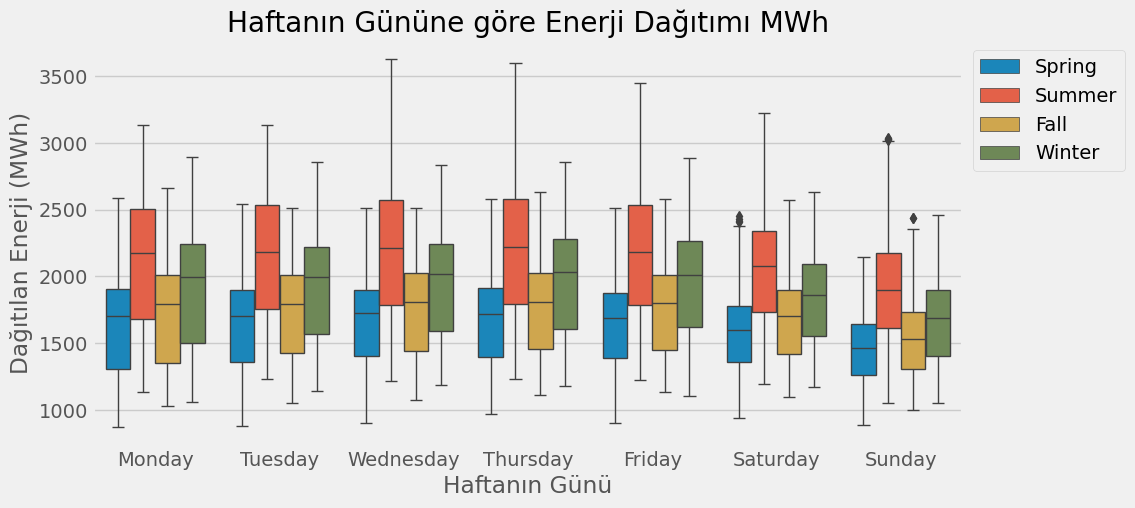

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Dağıtılan Enerji (MWh)',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Haftanın Gününe göre Enerji Dağıtımı MWh')
ax.set_xlabel('Haftanın Günü')
ax.set_ylabel('Dağıtılan Enerji (MWh)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# Train / Test Split

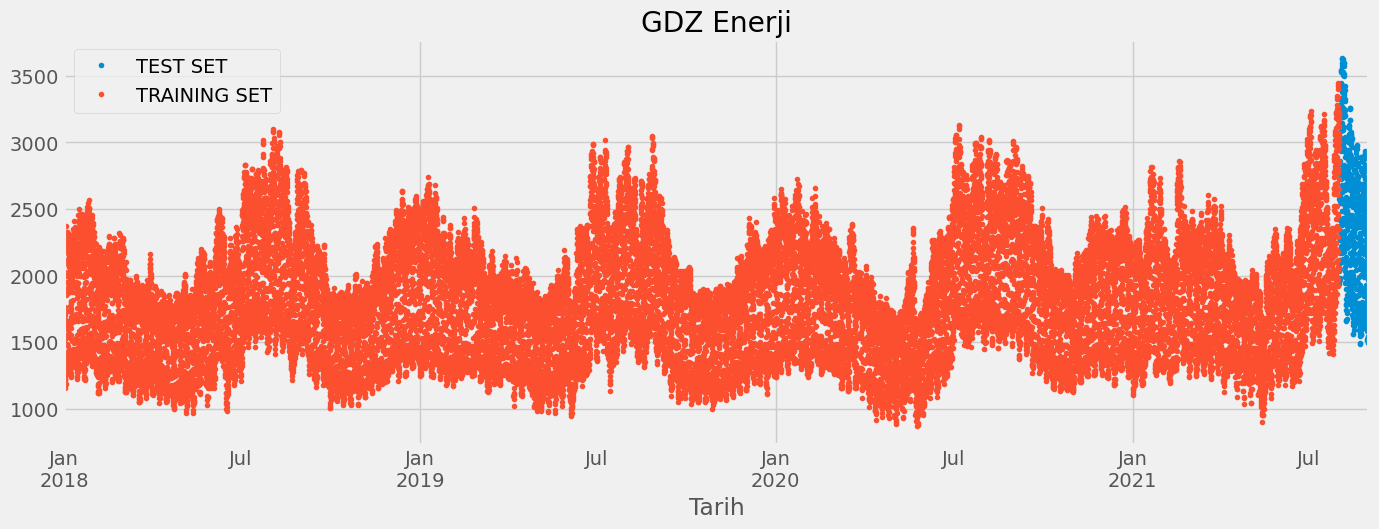

In [10]:
split_date = '2021-07-31 23:00:00'
check_date = '2021-08-31 23:00:00'
gdz_train = gdz.loc[gdz.index <= split_date].copy()
gdz_test = gdz.loc[(gdz.index > split_date) & (gdz.index < check_date)].copy()

# Plot train and test so you can see wher we have split
gdz_test \
        .rename(columns={'Dağıtılan Enerji (MWh)':'TEST SET'}) \
        .join(gdz_train.rename(columns={'Dağıtılan Enerji (MWh)':'TRAINING SET'}),
              how='outer') \
        .plot(figsize=(15,5), title='GDZ Enerji', style='.')
plt.show()

# Basit Prophet Model

Tarih kolonu : ds olmalı.

Hedef değişken : y olmalı.

In [11]:
# Format data for prophet model using ds and y
gdz_train_prophet = gdz_train.reset_index() \
.rename(columns={'Tarih':'ds',
                'Dağıtılan Enerji (MWh)':'y'})

In [12]:
gdz_train_prophet.head()

,ds,y
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701


In [13]:
%%time
model = Prophet()
model.fit(gdz_train_prophet)

16:52:20 - cmdstanpy - INFO - Chain [1] start processing
16:53:02 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.91 s, sys: 329 ms, total: 4.23 s
Wall time: 46.7 s


In [14]:
# Predict on test set with model
gdz_test_prophet = gdz_test.reset_index() \
.rename(columns={'Tarih':'ds',
                'Dağıtılan Enerji (MWh)':'y'})
gdz_test_fcst = model.predict(gdz_test_prophet)

In [15]:
gdz_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-08-01 00:00:00,1885.869627,1773.680288,2190.191035,1885.869627,1885.869627,93.941977,93.941977,93.941977,-177.220340,...,-161.111843,-161.111843,-161.111843,432.274159,432.274159,432.274159,0.0,0.0,0.0,1979.811604
1,2021-08-01 01:00:00,1885.862890,1639.557232,2055.293255,1885.862890,1885.862890,-40.362858,-40.362858,-40.362858,-303.707096,...,-168.928229,-168.928229,-168.928229,432.272468,432.272468,432.272468,0.0,0.0,0.0,1845.500032
2,2021-08-01 02:00:00,1885.856152,1545.961096,1967.287350,1885.856152,1885.856152,-134.450564,-134.450564,-134.450564,-390.604459,...,-176.116648,-176.116648,-176.116648,432.270544,432.270544,432.270544,0.0,0.0,0.0,1751.405589
3,2021-08-01 03:00:00,1885.849415,1464.018096,1899.389112,1885.849415,1885.849415,-202.547519,-202.547519,-202.547519,-452.200931,...,-182.614974,-182.614974,-182.614974,432.268386,432.268386,432.268386,0.0,0.0,0.0,1683.301895
4,2021-08-01 04:00:00,1885.842677,1410.658803,1839.168836,1885.842677,1885.842677,-255.282177,-255.282177,-255.282177,-499.182262,...,-188.365908,-188.365908,-188.365908,432.265992,432.265992,432.265992,0.0,0.0,0.0,1630.560500


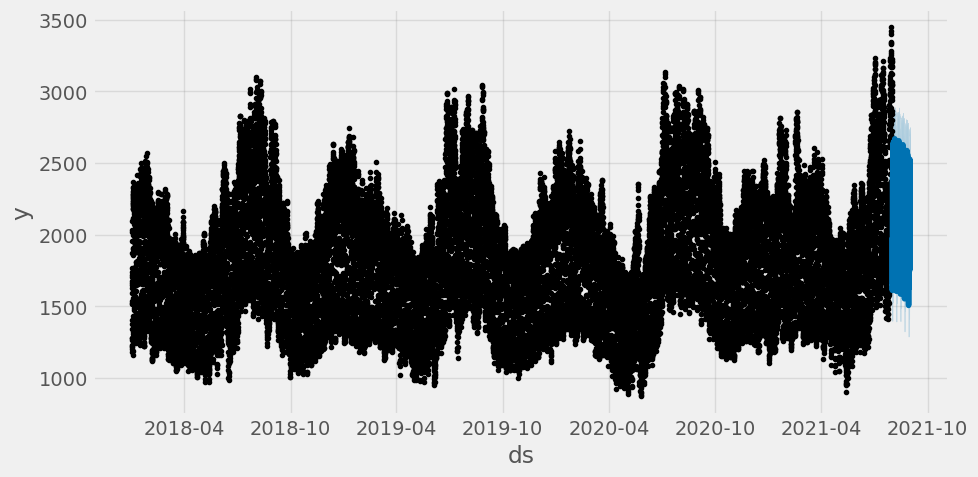

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(gdz_test_fcst, ax=ax)
plt.show()

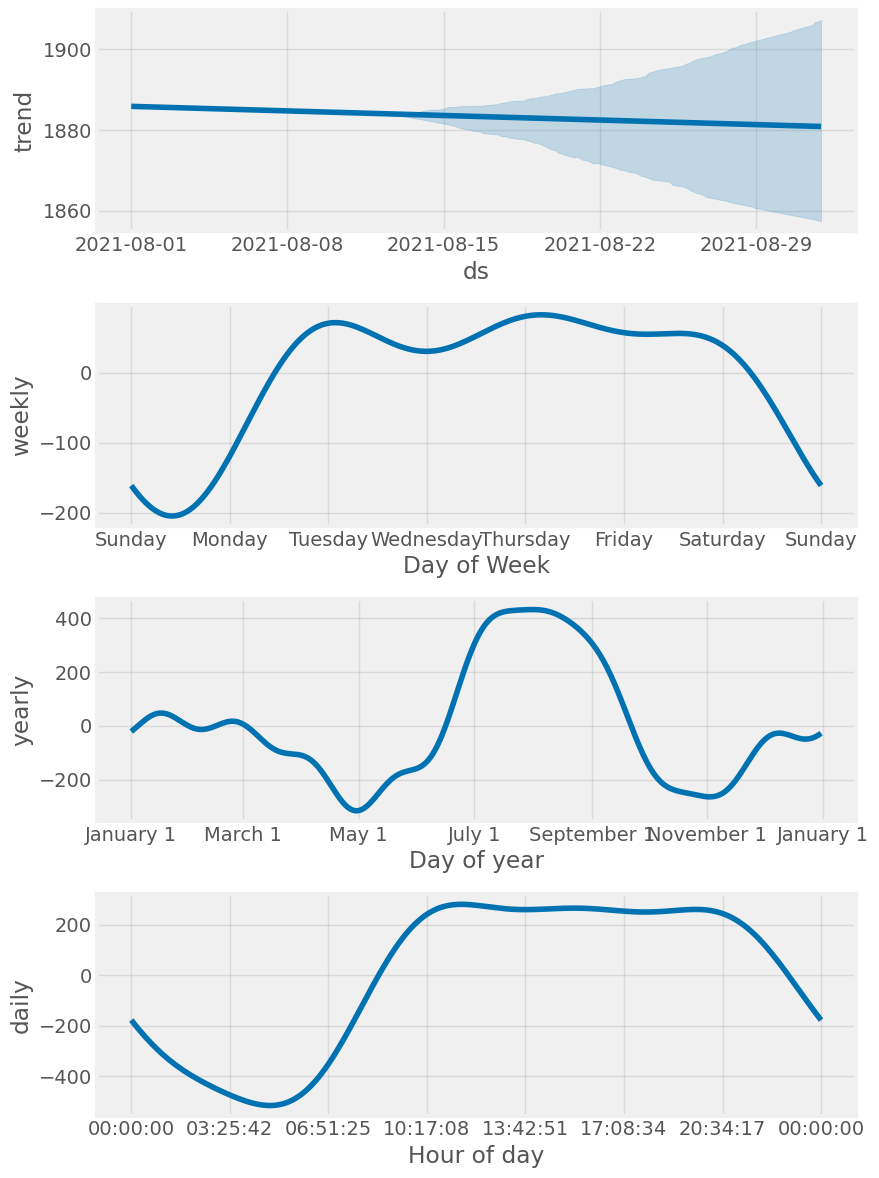

In [17]:
model.plot_components(gdz_test_fcst)
plt.show()

# Tahmin ile Gerçekleşen Değerlerin Kıyaslanması

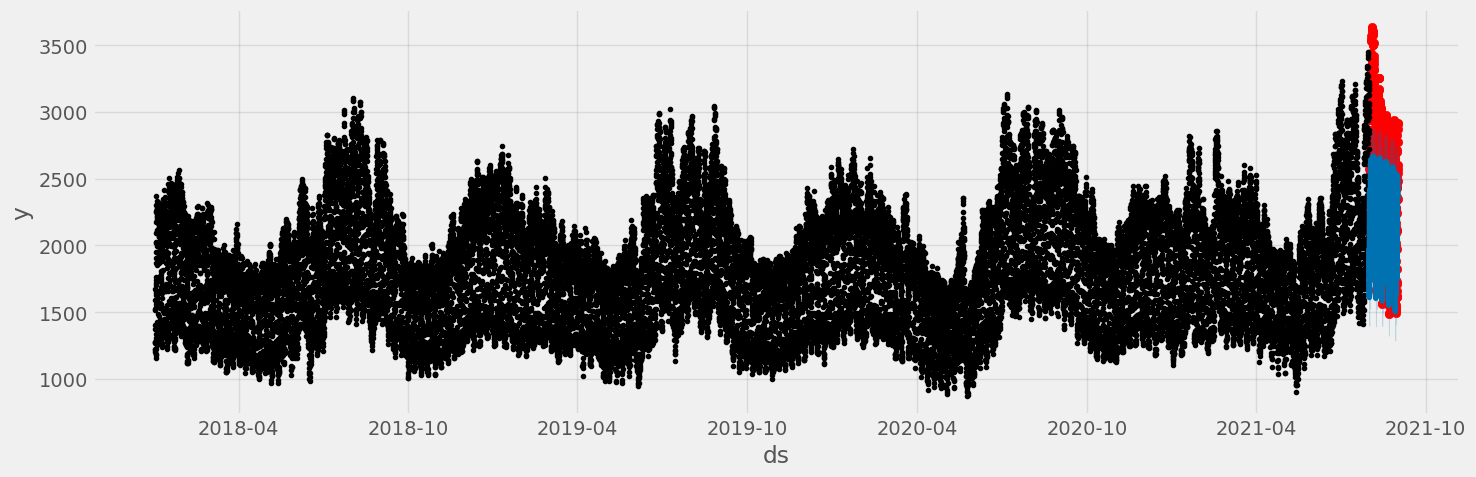

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(gdz_test.index, gdz_test['Dağıtılan Enerji (MWh)'], color='r')
fig = model.plot(gdz_test_fcst, ax=ax)

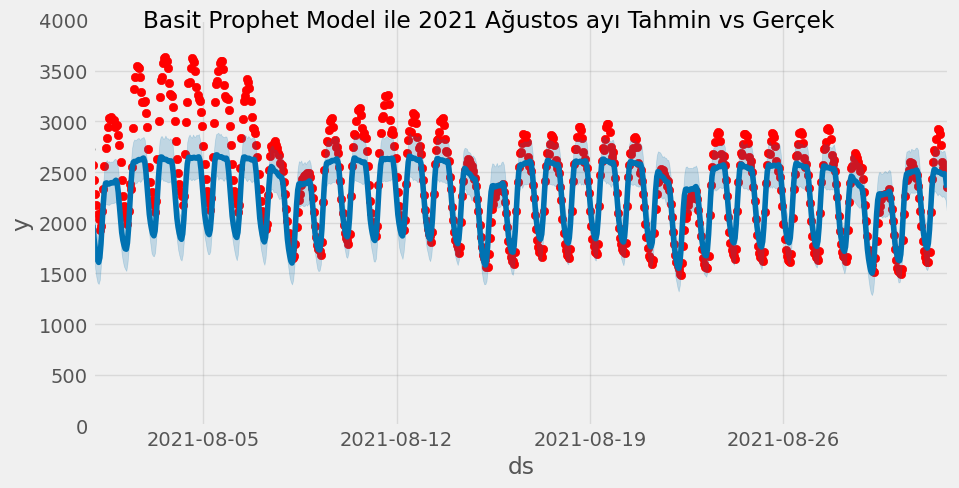

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(gdz_test.index, gdz_test['Dağıtılan Enerji (MWh)'], color='r')
fig = model.plot(gdz_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.date(2021, 8, 1),
              upper=datetime.date(2021, 9, 1))
ax.set_ylim(0, 4000)
plot = plt.suptitle('Basit Prophet Model ile 2021 Ağustos ayı Tahmin vs Gerçek')

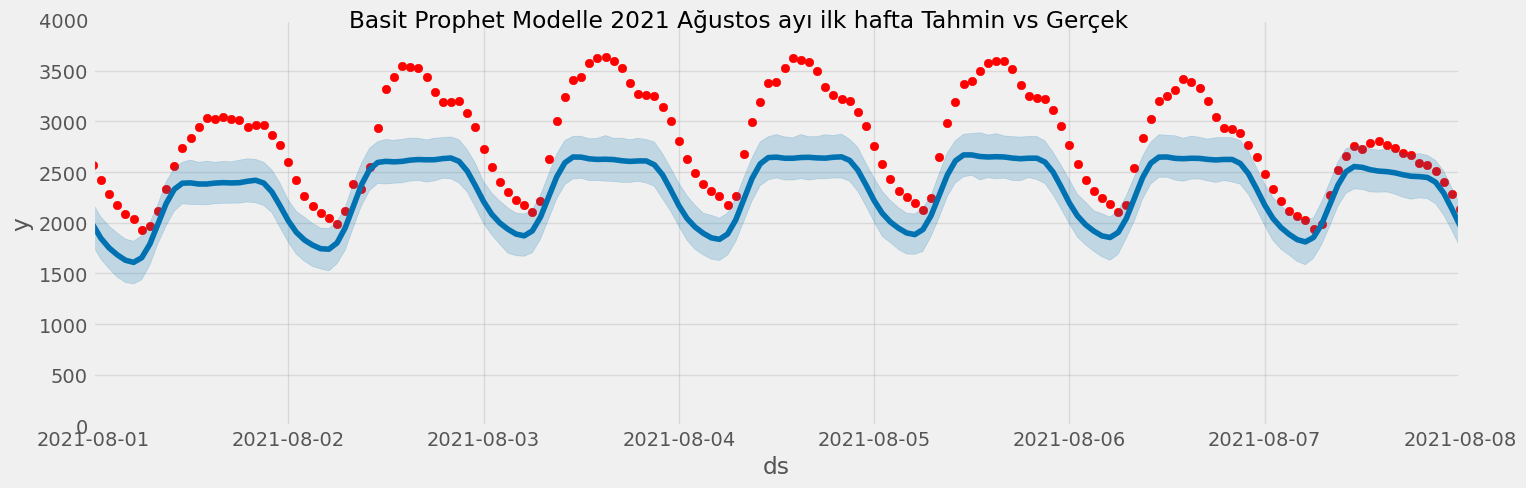

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(gdz_test.index, gdz_test['Dağıtılan Enerji (MWh)'], color='r')
fig = model.plot(gdz_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.date(2021, 8, 1),
              upper=datetime.date(2021, 8, 8))
ax.set_ylim(0, 4000)
plot = plt.suptitle('Basit Prophet Modelle 2021 Ağustos ayı ilk hafta Tahmin vs Gerçek')
plt.show()

# Modeli Hata Metrikleri ile Doğrulama

In [21]:
np.sqrt(mean_squared_error(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                          y_pred=gdz_test_fcst['yhat']))

305.90716527956135

In [22]:
mean_absolute_error(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                   y_pred=gdz_test_fcst['yhat'])

220.1126478092736

In [23]:
mean_absolute_percentage_error(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                   y_pred=gdz_test_fcst['yhat'])

0.08492371776617252

In [24]:
custom_mape(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                   y_pred=gdz_test_fcst['yhat'])

8.492371776617253

# Adding Holidays

In [25]:
yilbasi_tatil = ["2018-01-01","2019-01-01","2020-01-01","2021-01-01","2022-01-01"]

In [26]:
milli_tatil = ["2018-04-23","2018-05-01","2018-05-19","2018-07-15","2018-08-30","2018-10-28","2018-10-29",
               "2019-04-23","2019-05-01","2019-05-19","2019-07-15","2019-08-30","2019-10-28","2019-10-29",
               "2020-04-23","2020-05-01","2020-05-19","2020-07-15","2020-08-30","2020-10-28","2020-10-29",
               "2021-04-23","2021-05-01","2021-05-19","2021-07-15","2021-08-30","2021-10-28","2021-10-29",
               "2022-04-23","2022-05-01","2022-05-19","2022-07-15","2022-08-30","2022-10-28","2022-10-29",
              ]

In [27]:
ramazan_tatil = ["2018-06-14","2018-06-15","2018-06-16","2018-06-17",
                 "2019-06-03","2019-06-04","2019-06-05","2019-06-06",
                 "2020-05-23","2020-05-24","2020-05-25","2020-05-26",
                 "2021-05-12","2021-05-13","2021-05-14","2021-05-15",
                 "2022-05-01","2022-05-02","2022-05-03","2022-05-04",
                ]

In [28]:
kurban_tatil = ["2018-08-20","2018-08-21","2018-08-22","2018-08-23","2018-08-24",
                "2019-08-10","2019-08-11","2019-08-12","2019-08-13","2019-08-14",
                "2020-07-30","2020-07-31","2020-08-01","2020-08-02","2020-08-03",
                "2021-07-19","2021-07-20","2021-07-21","2021-07-22","2021-07-23",
                "2022-07-08","2022-07-09","2022-07-10","2022-07-11","2022-07-12" 
               ]

In [29]:
df_yilbasi = pd.DataFrame(index = yilbasi_tatil).assign(holiday="yilbasi_tatil")
df_milli = pd.DataFrame(index = milli_tatil).assign(holiday="milli_tatil")
df_ramazan = pd.DataFrame(index = ramazan_tatil).assign(holiday="ramazan_tatil")
df_kurban = pd.DataFrame(index = kurban_tatil).assign(holiday="kurban_tatil")
holiday_df = pd.concat([df_yilbasi,df_milli,df_ramazan,df_kurban])
holiday_df =holiday_df.reset_index().rename(columns={'index': 'ds'})
holiday_df.head()

,ds,holiday
0,2018-01-01,yilbasi_tatil
1,2019-01-01,yilbasi_tatil
2,2020-01-01,yilbasi_tatil
3,2021-01-01,yilbasi_tatil
4,2022-01-01,yilbasi_tatil


In [30]:
gdz_test_prophet.head()

,ds,y
0,2021-08-01 00:00:00,2571.230740
1,2021-08-01 01:00:00,2422.247527
2,2021-08-01 02:00:00,2286.023672
3,2021-08-01 03:00:00,2173.951400
4,2021-08-01 04:00:00,2085.294765


In [31]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')

# adding to train set
gdz_train_prophet['is_spring'] = gdz_train_prophet['ds'].apply(is_spring)
gdz_train_prophet['is_summer'] = gdz_train_prophet['ds'].apply(is_summer)
gdz_train_prophet['is_autumn'] = gdz_train_prophet['ds'].apply(is_autumn)
gdz_train_prophet['is_winter'] = gdz_train_prophet['ds'].apply(is_winter)
gdz_train_prophet['is_weekend'] = gdz_train_prophet['ds'].apply(is_weekend)
gdz_train_prophet['is_weekday'] = ~gdz_train_prophet['ds'].apply(is_weekend)

# adding to test set
gdz_test_prophet['is_spring'] = gdz_test_prophet['ds'].apply(is_spring)
gdz_test_prophet['is_summer'] = gdz_test_prophet['ds'].apply(is_summer)
gdz_test_prophet['is_autumn'] = gdz_test_prophet['ds'].apply(is_autumn)
gdz_test_prophet['is_winter'] = gdz_test_prophet['ds'].apply(is_winter)
gdz_test_prophet['is_weekend'] = gdz_test_prophet['ds'].apply(is_weekend)
gdz_test_prophet['is_weekday'] = ~gdz_test_prophet['ds'].apply(is_weekend)

In [32]:
gdz_train_prophet.head()

,ds,y,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
0,2018-01-01 00:00:00,1593.944216,False,False,False,True,False,True
1,2018-01-01 01:00:00,1513.933887,False,False,False,True,False,True
2,2018-01-01 02:00:00,1402.612637,False,False,False,True,False,True
3,2018-01-01 03:00:00,1278.527266,False,False,False,True,False,True
4,2018-01-01 04:00:00,1220.697701,False,False,False,True,False,True


In [33]:
gdz_test_prophet.head()

,ds,y,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
0,2021-08-01 00:00:00,2571.230740,False,True,False,False,False,True
1,2021-08-01 01:00:00,2422.247527,False,True,False,False,False,True
2,2021-08-01 02:00:00,2286.023672,False,True,False,False,False,True
3,2021-08-01 03:00:00,2173.951400,False,True,False,False,False,True
4,2021-08-01 04:00:00,2085.294765,False,True,False,False,False,True


Prophet forecaster.

Parameters
----------

**growth:** String 'linear' or 'logistic' to specify a linear or logistic
    trend.
    
**changepoints:** List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
    
**n_changepoints:** Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changepoints are selected uniformly from
    the first `changepoint_range` proportion of the history.
    
**changepoint_range:** Proportion of history in which trend changepoints will
    be estimated. Defaults to 0.8 for the first 80%. Not used if
    `changepoints` is specified.
    
**yearly_seasonality:** Fit yearly seasonality.
    Can be 'auto', True, False, or a number of Fourier terms to generate.
    
**weekly_seasonality:** Fit weekly seasonality.
    Can be 'auto', True, False, or a number of Fourier terms to generate.
    
**daily_seasonality:** Fit daily seasonality.
    Can be 'auto', True, False, or a number of Fourier terms to generate.
    
**holidays:** pd.DataFrame with columns holiday (string) and ds (date type)
    and optionally columns lower_window and upper_window which specify a
    range of days around the date to be included as holidays.
    lower_window=-2 will include 2 days prior to the date as holidays. Also
    optionally can have a column prior_scale specifying the prior scale for
    that holiday.
    
**seasonality_mode:** 'additive' (default) or 'multiplicative'.

**seasonality_prior_scale:** Parameter modulating the strength of the
    seasonality model. Larger values allow the model to fit larger seasonal
    fluctuations, smaller values dampen the seasonality. Can be specified
    for individual seasonalities using add_seasonality.
    
**holidays_prior_scale:** Parameter modulating the strength of the holiday
    components model, unless overridden in the holidays input.
    
**changepoint_prior_scale:** Parameter modulating the flexibility of the
    automatic changepoint selection. Large values will allow many
    changepoints, small values will allow few changepoints.
    
**mcmc_samples:** Integer, if greater than 0, will do full Bayesian inference
    with the specified number of MCMC samples. If 0, will do MAP
    estimation.
    
**interval_width:** Float, width of the uncertainty intervals provided
    for the forecast. If mcmc_samples=0, this will be only the uncertainty
    in the trend using the MAP estimate of the extrapolated generative
    model. If mcmc.samples>0, this will be integrated over all model
    parameters, which will include uncertainty in seasonality.
    
**uncertainty_samples:** Number of simulated draws used to estimate
    uncertainty intervals. Settings this value to 0 or False will disable
    uncertainty estimation and speed up the calculation.
    
**stan_backend:** str as defined in StanBackendEnum default: None - will try to
    iterate over all available backends and find the working one

In [34]:
%%time
model_with_holidays = Prophet(growth='linear',
                              changepoints=None,
                              n_changepoints=30, 
                              changepoint_range=0.80,
                              yearly_seasonality=False,
                              weekly_seasonality=False,
                              daily_seasonality=False,
                              holidays=holiday_df,
                              seasonality_mode='multiplicative',
                              seasonality_prior_scale=12.0,
                              holidays_prior_scale=10.0,
                              changepoint_prior_scale=0.01,
                              mcmc_samples=0,
                              interval_width=0.80,
                              uncertainty_samples=1000,
                              stan_backend=None)
model_with_holidays.add_seasonality(name='yearly', period=365.25, fourier_order=20)
#### weekly
model_with_holidays.add_seasonality(name='weekly_spring', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_spring')
model_with_holidays.add_seasonality(name='weekly_summer', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_summer')
model_with_holidays.add_seasonality(name='weekly_autumn', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_autumn')
model_with_holidays.add_seasonality(name='weekly_winter', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_winter')
#### daily
model_with_holidays.add_seasonality(name='daily_spring',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')
model_with_holidays.add_seasonality(name='daily_summer',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')
model_with_holidays.add_seasonality(name='daily_autumn',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')
model_with_holidays.add_seasonality(name='daily_winter',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')

model_with_holidays.add_seasonality(name='daily_weekend',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekend')
model_with_holidays.add_seasonality(name='daily_weekday',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekday')
model_with_holidays.fit(gdz_train_prophet)

16:53:17 - cmdstanpy - INFO - Chain [1] start processing
16:54:16 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 9.24 s, sys: 499 ms, total: 9.74 s
Wall time: 1min 9s


In [35]:
# Predict on training set with model
gdz_test_fcst_with_hols = model_with_holidays.predict(df=gdz_test_prophet)

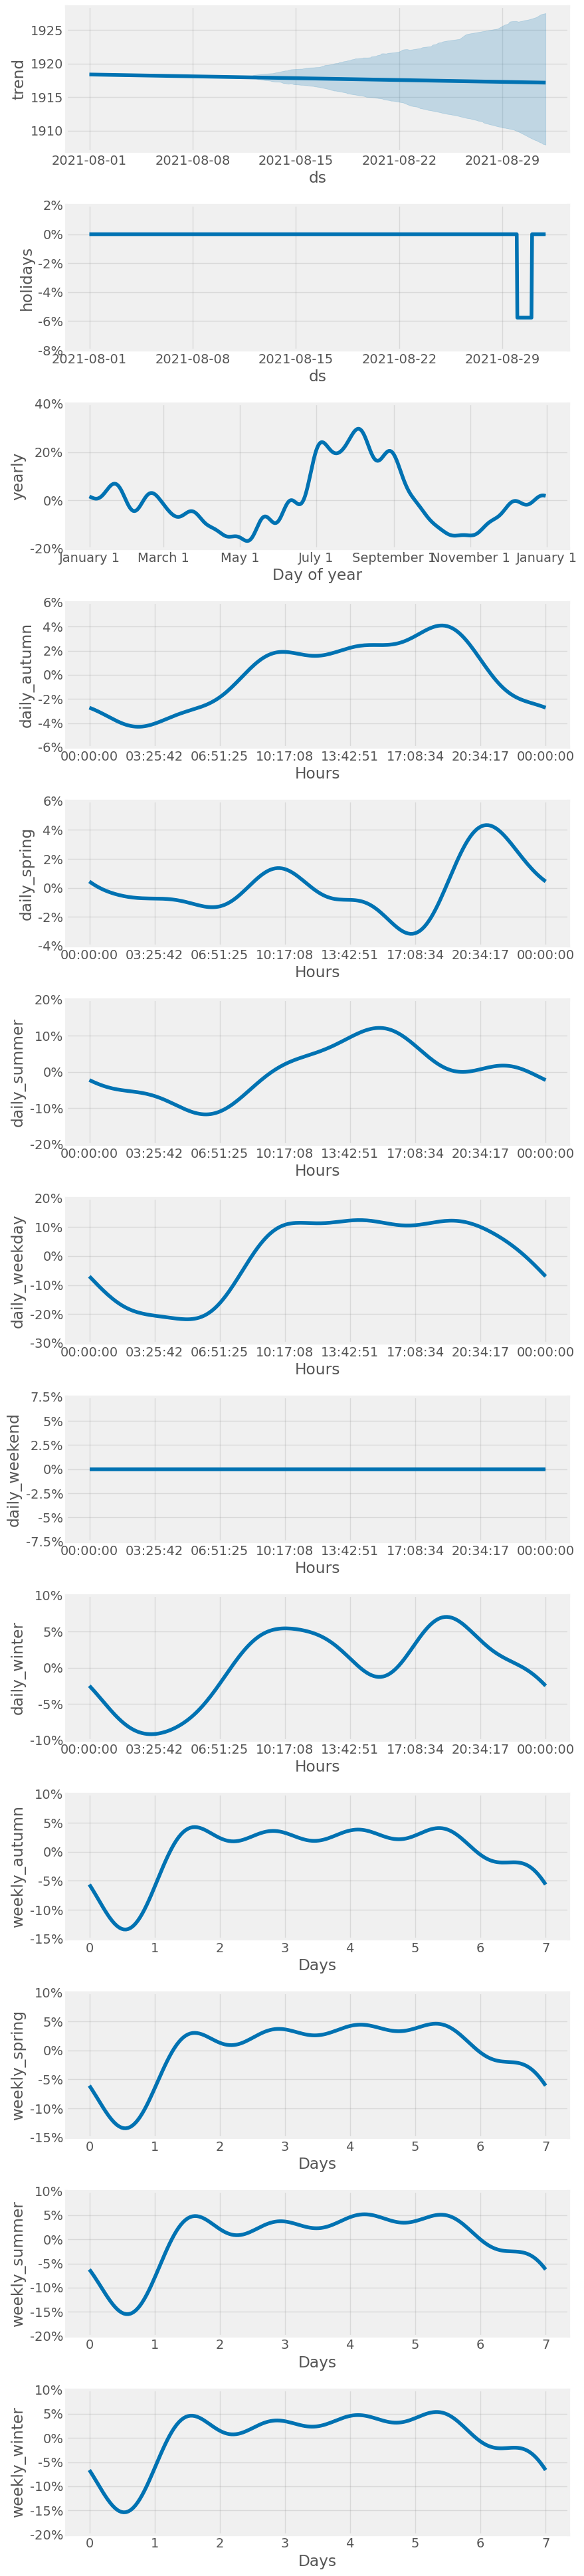

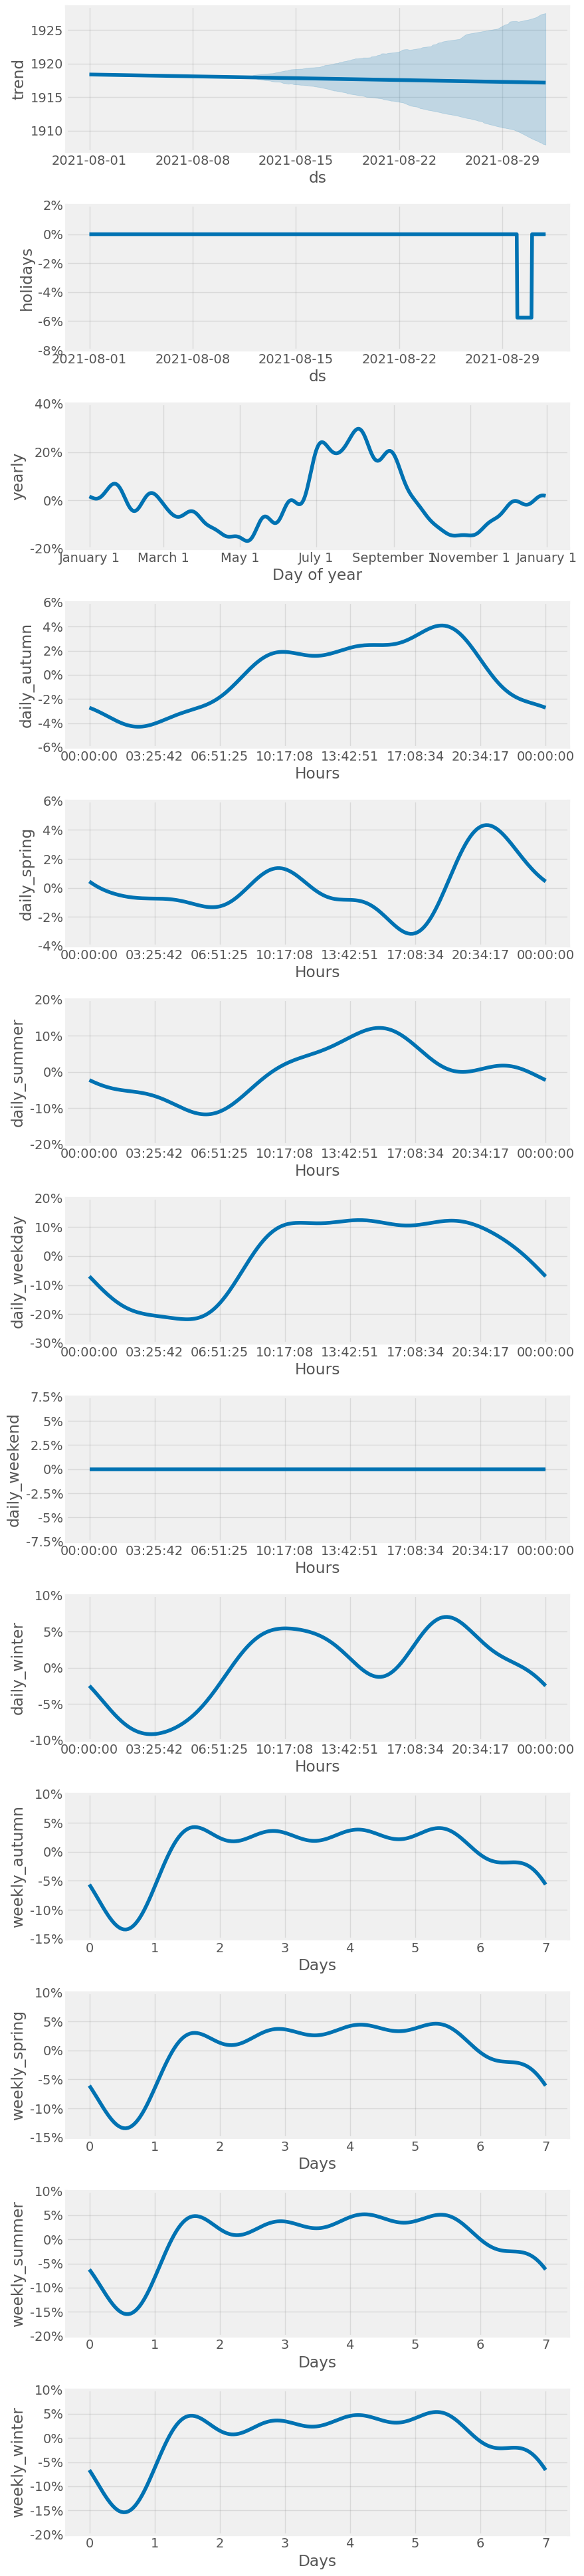

In [36]:
model_with_holidays.plot_components(gdz_test_fcst_with_hols)

In [37]:
gdz_test_fcst_with_hols.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily_autumn,daily_autumn_lower,daily_autumn_upper,daily_spring,...,yearly,yearly_lower,yearly_upper,yilbasi_tatil,yilbasi_tatil_lower,yilbasi_tatil_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-08-01 00:00:00,1918.365354,2013.769762,2349.710009,1918.365354,1918.365354,0.0,0.0,0.0,0.0,...,0.289055,0.289055,0.289055,0.0,0.0,0.0,0.0,0.0,0.0,2176.510131
1,2021-08-01 01:00:00,1918.363719,1828.725472,2165.552255,1918.363719,1918.363719,0.0,0.0,0.0,0.0,...,0.289282,0.289282,0.289282,0.0,0.0,0.0,0.0,0.0,0.0,1998.571123
2,2021-08-01 02:00:00,1918.362085,1706.376479,2047.858325,1918.362085,1918.362085,0.0,0.0,0.0,0.0,...,0.289505,0.289505,0.289505,0.0,0.0,0.0,0.0,0.0,0.0,1877.524595
3,2021-08-01 03:00:00,1918.360450,1632.876295,1972.238088,1918.360450,1918.360450,0.0,0.0,0.0,0.0,...,0.289726,0.289726,0.289726,0.0,0.0,0.0,0.0,0.0,0.0,1806.059000
4,2021-08-01 04:00:00,1918.358815,1569.557649,1905.306920,1918.358815,1918.358815,0.0,0.0,0.0,0.0,...,0.289944,0.289944,0.289944,0.0,0.0,0.0,0.0,0.0,0.0,1737.366288


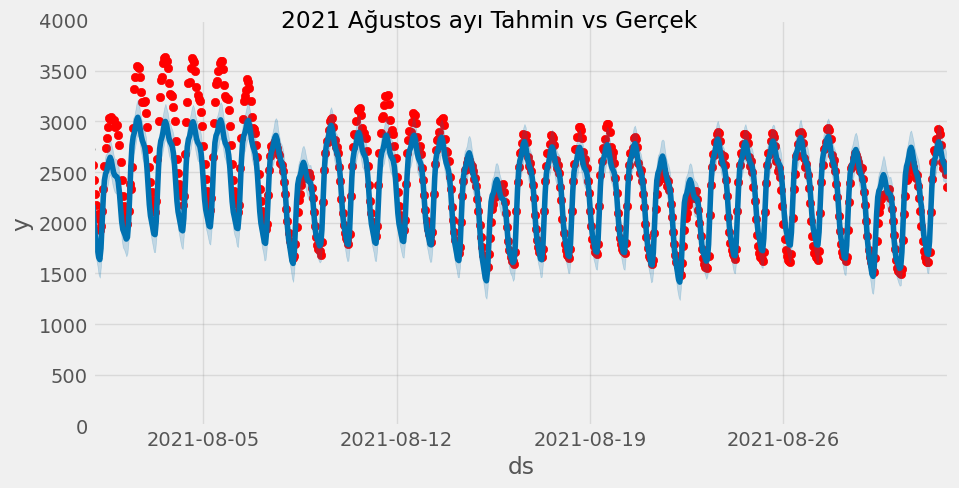

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(gdz_test.index, gdz_test['Dağıtılan Enerji (MWh)'], color='r')
fig = model.plot(gdz_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower=datetime.date(2021, 8, 1),
              upper=datetime.date(2021, 9, 1))
ax.set_ylim(0, 4000)
plot = plt.suptitle('2021 Ağustos ayı Tahmin vs Gerçek')

In [39]:
np.sqrt(mean_squared_error(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                          y_pred=gdz_test_fcst_with_hols['yhat']))

208.8260575638384

In [40]:
mean_absolute_error(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                   y_pred=gdz_test_fcst_with_hols['yhat'])

148.40186515685258

In [41]:
mean_absolute_percentage_error(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                   y_pred=gdz_test_fcst_with_hols['yhat'])

0.05778720874751592

In [42]:
custom_mape(y_true=gdz_test['Dağıtılan Enerji (MWh)'],
                   y_pred=gdz_test_fcst_with_hols['yhat'])

5.778720874751592

# Geleceği Tahmin Etmek

In [43]:
future = model_with_holidays.make_future_dataframe(periods=31*24, freq='h', include_history=False) + pd.Timedelta('365 days')

In [44]:
# adding to test set
future['is_spring'] = future['ds'].apply(is_spring)
future['is_summer'] = future['ds'].apply(is_summer)
future['is_autumn'] = future['ds'].apply(is_autumn)
future['is_winter'] = future['ds'].apply(is_winter)
future['is_weekend'] = future['ds'].apply(is_weekend)
future['is_weekday'] = ~future['ds'].apply(is_weekend)

In [45]:
future.tail()

,ds,is_spring,is_summer,is_autumn,is_winter,is_weekend,is_weekday
739,2022-08-31 19:00:00,False,True,False,False,False,True
740,2022-08-31 20:00:00,False,True,False,False,False,True
741,2022-08-31 21:00:00,False,True,False,False,False,True
742,2022-08-31 22:00:00,False,True,False,False,False,True
743,2022-08-31 23:00:00,False,True,False,False,False,True


In [46]:
forecast = model_with_holidays.predict(future)

In [47]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily_autumn,daily_autumn_lower,daily_autumn_upper,daily_spring,...,yearly,yearly_lower,yearly_upper,yilbasi_tatil,yilbasi_tatil_lower,yilbasi_tatil_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-08-01 00:00:00,1904.045770,1957.137772,2310.825759,1904.045770,1904.045770,0.0,0.0,0.0,0.0,...,0.287636,0.287636,0.287636,0.0,0.0,0.0,0.0,0.0,0.0,2123.708797
1,2022-08-01 01:00:00,1904.044135,1812.289087,2161.087770,1904.044135,1904.044135,0.0,0.0,0.0,0.0,...,0.287879,0.287879,0.287879,0.0,0.0,0.0,0.0,0.0,0.0,1986.679719
2,2022-08-01 02:00:00,1904.042500,1746.087064,2081.544894,1904.042500,1904.042500,0.0,0.0,0.0,0.0,...,0.288120,0.288120,0.288120,0.0,0.0,0.0,0.0,0.0,0.0,1907.512282
3,2022-08-01 03:00:00,1904.040866,1720.012296,2059.030580,1904.040866,1904.040866,0.0,0.0,0.0,0.0,...,0.288358,0.288358,0.288358,0.0,0.0,0.0,0.0,0.0,0.0,1878.218472
4,2022-08-01 04:00:00,1904.039231,1671.771032,2022.591293,1904.039231,1904.039231,0.0,0.0,0.0,0.0,...,0.288593,0.288593,0.288593,0.0,0.0,0.0,0.0,0.0,0.0,1851.575053


In [48]:
forecast[['ds','yhat']]

,ds,yhat
0,2022-08-01 00:00:00,2123.708797
1,2022-08-01 01:00:00,1986.679719
2,2022-08-01 02:00:00,1907.512282
3,2022-08-01 03:00:00,1878.218472
4,2022-08-01 04:00:00,1851.575053
...,...,...
739,2022-08-31 19:00:00,2577.947482
740,2022-08-31 20:00:00,2558.794525
741,2022-08-31 21:00:00,2534.207832
742,2022-08-31 22:00:00,2471.492419


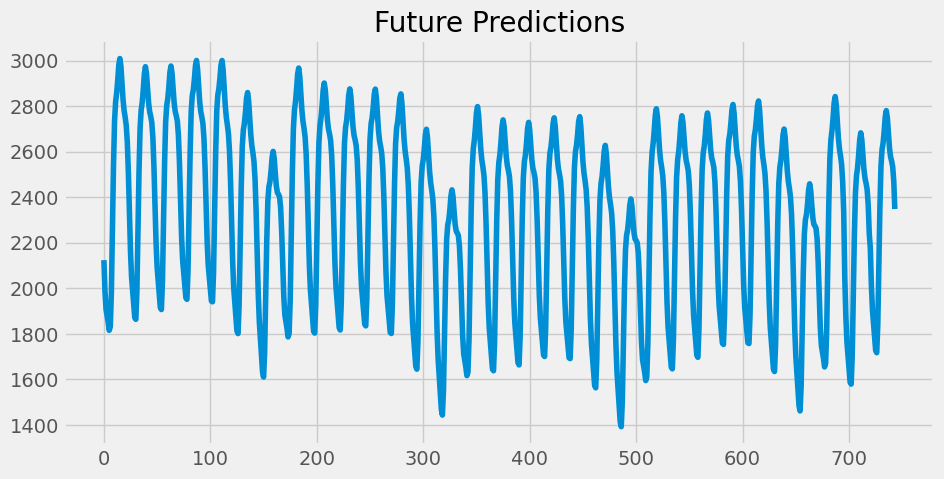

In [49]:
forecast["yhat"].plot(figsize=(10, 5),title='Future Predictions')
plt.show()

In [50]:
df_submission = forecast[['ds','yhat']]
df_submission.set_index("ds", drop=True,inplace=True)
df_submission.index.name = 'Tarih'
df_submission = df_submission.rename(columns={'yhat':'Dağıtılan Enerji (MWh)'})
df_submission.to_csv('submission.csv')

In [51]:
df_submission

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2123.708797
2022-08-01 01:00:00,1986.679719
2022-08-01 02:00:00,1907.512282
2022-08-01 03:00:00,1878.218472
2022-08-01 04:00:00,1851.575053
...,...
2022-08-31 19:00:00,2577.947482
2022-08-31 20:00:00,2558.794525
2022-08-31 21:00:00,2534.207832


# Kaynakça

https://www.youtube.com/watch?v=j0eioK5edqg&list=RDCMUCxladMszXan-jfgzyeIMyvw&index=2&ab_channel=RobMulla